In [106]:
from itertools import product
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

class cube:
    def __init__(self, x, ys, xs, cube_length, d=1, reward=0):
        '''
        Parameters
        ----------
        x : TYPE: list or numpy.array
            'bottom left' point of initial cube, 
            'bottom left' means the coordinates of other points in the cube are not less than this point
            for example: the 'bottom left' point of cube [(0,0),(1,0),(0,1),(1,1)] is (0,0)
        cube_length : TYPE: float
            edge length of cube
        d : TYPE, int
            dimension of cube
        reward: TYPE, float
            mean reward of the cube
        '''
        self.x = x
        self.cube_length = cube_length
        self.d = d
        self.ys = ys
        self.xs = xs       
        self.children = []
        
        
    def split(self):
        '''split by dyadic'''
        new_cube_length = self.cube_length / 2
        candidate_idx = np.array(list(product([0,1], repeat=self.d)))
        for idx in candidate_idx:
            new_x = self.x + idx * new_cube_length
            if not np.array(self.xs).any():
                new_cube = cube(new_x, [], [], new_cube_length)
            else:
                new_xs, new_ys = self.update_xy(self.xs, self.ys, new_x, new_cube_length)
                new_cube = cube(new_x, new_ys, new_xs, new_cube_length)
            new_cube.parent = self
            self.children.append(new_cube)
        return self.children
    
    
    def insert_point(self, x, y):
        if (x >= self.x).all() and (x <= (self.x+self.cube_length)).all():
            self.xs.append(x)
            self.ys.append(y)
    

        
    def update_xy(self, parent_xs, parent_ys, child_x, child_cube_length):
        xs = np.array(parent_xs).copy()
        ys = np.array(parent_ys).copy()
        condition = ((xs >= child_x) & (xs <= child_x + child_cube_length)).all(axis=1)
        try:
            return xs[condition], ys[condition]
        except:
            print(child_x)
            print(ys.shape)
    
    
    
    def mean_reward(self):
        return np.mean(self.ys)
    
    
class BMO_E:
    def __init__(self, T, init_x, init_cube_length, eta, epsilon, c, delta, split_times=1):        
        self.init_cubes = [cube(np.array(init_x), [], [], init_cube_length)]
        self.T = T   #time horizon
        self.s_cubes = []  #cubes surviving each batch
        self.cubes = []    #cubes played each batch
        self.count = 0     #number of times arm has been played
        self.eta = eta
        self.epsilon = epsilon
        self.delta = delta
        self.rewards = []
        self.arms = []
        self.delta_regret = 0
        self.split_times = split_times
        self.c = c
        self.isfinal = 0

        
    
    def initialize(self):
        
        # calcalate f_delta
#         print('------initialize--------')
        linspace = np.linspace(-1,1,100000)
        arms = list(product(linspace, repeat=1))
        fun_values = []
#         print('get f_delta:')
        for arm in arms:
            if arm == 0:
                continue
            fun_values.append(self.get_reward(arm)[1])
        self.tmp = fun_values
        fun_values = np.array(fun_values)
        self.delta_regret = np.quantile(fun_values, 1-self.delta)
        self.m_regret = np.max(fun_values)
        
        
#         print('----play batch 0 ------')
        cubes = self.init_cubes
        for i in range(self.split_times):
            cubes = self.partition(cubes)
        self.cubes.append(cubes)
        
        nb, Jb = self.values4batch()
#         print('Jb', Jb)
        self.play_one_batch(cubes, nb)
#         print('have play {} times totally'.format(self.count))
        
        s_cubes = self.elimination(cubes, Jb)
        self.s_cubes.append(s_cubes)
        
        
          
    def values4batch(self):
        cube_length = self.cubes[-1][-1].cube_length
        d = self.cubes[-1][-1].d
        mu_cube = pow(cube_length, d)
        
        numerator = np.log(self.T**2/self.epsilon) + np.log2(1/self.eta)
        
        if pow(cube_length/2, d) <= self.eta:   #play final batch
            nb = np.ceil((self.T-self.count) / len(self.cubes[-1]))
            self.isfinal = 1
        else:
            denominator = self.c*np.log(mu_cube/self.eta)
            nb = max(np.floor(numerator /denominator), 1)
            
        print(nb)
        return int(nb), self.c*np.log(mu_cube/self.eta)
        
        
    def partition(self, cubes):
        '''
        cubes: list of cubes to be split
        '''
        new_cubes = []
        for cube in cubes:
            new_cubes_ = cube.split()
            new_cubes += new_cubes_
        return new_cubes
    
    
    
    def play_one_batch(self, cubes, nb):
#         print('every cube need to be played {} times this batch'.format(nb))
            
        for i in range(nb):
            for cube in cubes:
                if len(cube.xs) > nb and not self.isfinal:
                    continue
                arm = self.sample(cube)
                self.arms.append(arm)
                observation, reward = self.get_reward(arm)
                cube.xs = list(cube.xs) + [arm]
                cube.ys = list(cube.ys) + [observation]
                self.rewards.append(reward)      
                self.count += 1
                
                if self.count >= self.T:
                    break
                
            if self.count >= self.T:
                break           

                
                

    def elimination(self, cubes, Jb):
        rewards = [cube.mean_reward() for cube in cubes]
        max_reward = np.max(rewards)
        rewards_diff = max_reward - rewards
        s_cubes_idx = np.where(rewards_diff <= (2*self.c+1)*Jb)[0]
        s_cubes = [cubes[idx] for idx in s_cubes_idx]
        return s_cubes
                
        
    def sample(self, cube):
        arm = np.random.uniform(cube.x, cube.x+cube.cube_length)
        while arm == 0:
            arm = np.random.uniform(cube.x, cube.x+cube.cube_length)
        return arm
     
        
    def get_reward(self, arm):
        x = arm[0]
        if x <= 0.5:
            reward = - np.log(abs(x))
        else:
            x = x * 5 - 7
            reward = (200 - x**4 + 16*x**2 - 5*x) / 80
        observation = np.random.normal(reward, 0.1)
        return observation, reward

#     def get_reward(self, arm):
#         x = arm[0]
#         reward = -np.log(abs(x))
#         observation = np.random.normal(reward, 0.1)
#         return observation, reward
    

    
    def play(self):
        self.initialize()
        for b in range(1, self.T):
#             print('----play batch {} ------'.format(b))
            cubes = self.partition(self.s_cubes[-1])
                
            self.cubes.append(cubes)
            nb, Jb = self.values4batch()
#             print('Jb', Jb)

            self.play_one_batch(cubes, nb)
#             print('have play {} times totally'.format(self.count))

            if self.count >= self.T:
                break
            
            s_cubes = self.elimination(cubes, Jb)
            self.s_cubes.append(s_cubes)
            
            
    def plot(self):
        self.play()
        rewards = self.rewards
        delta_regret = self.delta_regret
        m_regret = self.m_regret
        delta_regrets = [max(0, delta_regret - reward) for reward in rewards]
        regrets = [(m_regret - reward) for reward in rewards]

        print('cubes num:', [len(cubes) for cubes in self.cubes])
        print('s_cubes num:', [len(cubes) for cubes in self.s_cubes])
        
        return delta_regrets, regrets
    

In [108]:
T = 10000
init_x = [-1]
init_cube_length = 2
eta = 1e-5
epsilon = 1e-2
delta = 1e-3
phi = 0.1
split_times = 1

regrets_all = []
regrets_delta_all = []
for _ in range(10):
    A = BMO_E(T, init_x, init_cube_length, eta, epsilon, phi, delta, split_times=split_times)
    regrets_delta, regrets = A.plot()
    regrets_all.append(regrets)
    regrets_delta_all.append(regrets_delta)

34.0
36.0
39.0
42.0
45.0
49.0
53.0
59.0
66.0
75.0
86.0
101.0
124.0
158.0
219.0
355.0
3654.0
cubes num: [2, 2, 4, 6, 8, 14, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
s_cubes num: [1, 2, 3, 4, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
34.0
36.0
39.0
42.0
45.0
49.0
53.0
59.0
66.0
75.0
cubes num: [2, 2, 2, 4, 8, 14, 28, 54, 104, 202]
s_cubes num: [1, 1, 2, 4, 7, 14, 27, 52, 101]
34.0
36.0
39.0
42.0
45.0
49.0
53.0
59.0
66.0
75.0
cubes num: [2, 2, 2, 4, 8, 14, 28, 54, 104, 204]
s_cubes num: [1, 1, 2, 4, 7, 14, 27, 52, 102]
34.0
36.0
39.0
42.0
45.0
49.0
53.0
59.0
66.0
75.0
86.0
101.0
124.0
158.0
219.0
355.0
3630.0
cubes num: [2, 2, 4, 6, 10, 14, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
s_cubes num: [1, 2, 3, 5, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
34.0
36.0
39.0
42.0
45.0
49.0
53.0
59.0
66.0
75.0
86.0
101.0
124.0
158.0
219.0
355.0
3487.0
cubes num: [2, 2, 4, 6, 10, 16, 16, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
s_cubes num: [1, 2, 3, 5, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


KeyboardInterrupt: 

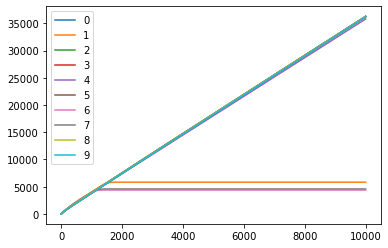

In [102]:
import matplotlib.pyplot as plt
import numpy as np
# for i in range(1):
#     plt.plot(np.cumsum(regrets_all, axis=1)[i], label='{}'.format(i))
# plt.legend()
# plt.show()

for i in range(10):
    plt.plot(np.cumsum(regrets_delta_all, axis=1)[i], label='{}'.format(i))
plt.legend()
plt.show()

In [103]:
regret_m = np.mean(np.cumsum(regrets_all, axis=1), axis=0)
regret_std = np.std(np.cumsum(regrets_all, axis=1), axis=0)
regret_m_delta = np.mean(np.cumsum(regrets_delta_all, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(regrets_delta_all, axis=1), axis=0)

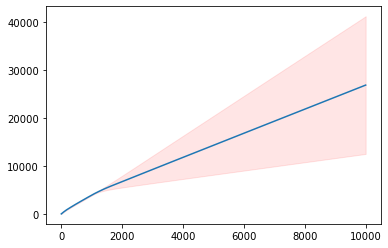

In [104]:
plt.plot(regret_m_delta)
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [36]:
import numpy as np
np.savetxt(f'bmoe_delta_{40}.csv', regrets_delta_all)
# np.savetxt('bmo_eli.csv', regrets_all)